In [2]:
 #load Raw data from TDT ECoG maschine, plz run ""
import numpy as np
import scipy.io as scio
from scipy import signal
import tdt
import os
import  wave
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft
from random import shuffle
import h5py
import scipy.io as scio
import scipy.io.wavfile
import math
import mne
import torch   
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [3]:
ecog_data=np.load('/public/DATA/overt_reading/processed_data/HS86/500/HS84-20231221-240111-114632.npy')
print(ecog_data.shape)

(256, 202360)


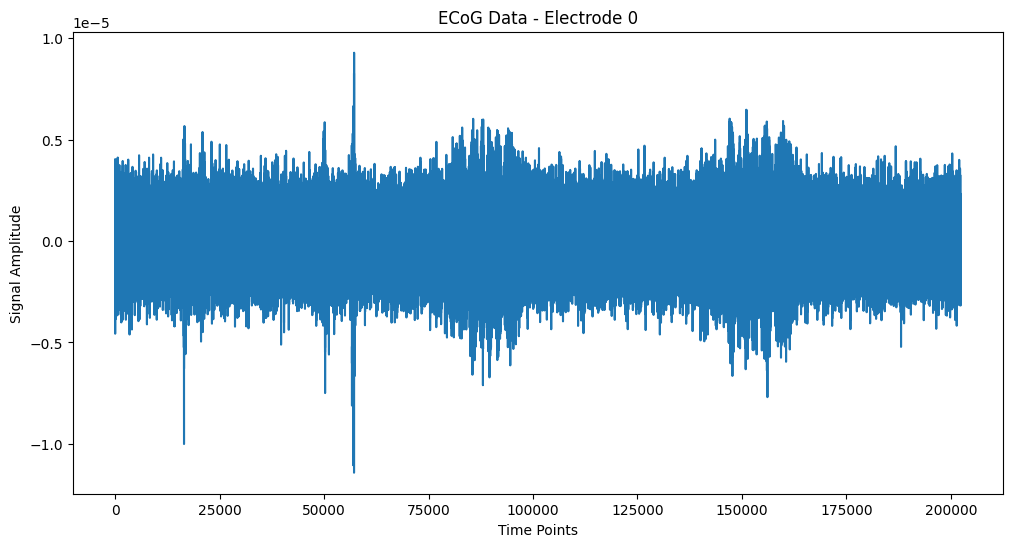

In [4]:
import matplotlib.pyplot as plt

# 假设 ecog_data 是形状为 (256, 153366) 的数据
# 选择第一个电极进行可视化
electrode_index = 0
plt.figure(figsize=(12, 6))
plt.plot(ecog_data[electrode_index, :])
plt.title(f'ECoG Data - Electrode {electrode_index}')
plt.xlabel('Time Points')
plt.ylabel('Signal Amplitude')
plt.show()

In [5]:
num_electrodes = ecog_data.shape[0]
plt.figure(figsize=(15, 2 * num_electrodes))

for i in range(num_electrodes):
    plt.subplot(num_electrodes, 1, i + 1)
    plt.plot(ecog_data[i, :])
    plt.title(f'Electrode {i}')
    plt.xlabel('Time Points')
    plt.ylabel('Signal Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
# calculate spectrogram for the 184 electrode
b=ecog_data[184,:]
c=mne.time_frequency.stft(b,800,tstep=2)

In [ ]:
c.shape

In [ ]:
d = c[0, :, :400]
d.shape

In [ ]:
d=(d-np.mean(d,axis=1,keepdims=True))/np.std(d,axis=1,keepdims=True)
d.shape

In [ ]:
plt.imshow(np.abs(d),cmap='coolwarm',interpolation='nearest')
plt.show()

In [ ]:
PATH='/public/DATA/overt_reading/points'
cue_points=np.load(os.path.join(PATH,'HS86_oneset_cue_point.npy'),allow_pickle=True)
read_points=np.load(os.path.join(PATH,'HS86_onset_read_time.npy'),allow_pickle=True)
delay=np.load(os.path.join(PATH,'HS86_delay_list.npy'),allow_pickle=True)

In [ ]:
cue_points

In [ ]:
def transfer(self, x, block):
        return int((int(x) * 24.414 - self.delay_list[str(block)]) / 24414 * 400)

In [ ]:
def calculating_time(time,delay,freq):
    '''
    description: 根据delay计算新的时间点
    time：需要转换的时间字典dict：{'blockid': [time]}
    '''
    fs=24414
    # print(delay)
    time = time.cpu().numpy()
    time=time.astype(np.float64)
    delay/=fs
    time/=1000
    time-=delay
    time=time*(freq/2)
    return time.astype(int)

In [ ]:
def map_dist(dist):
    code_dist=[]
    for word in dist:
        if word=='功课':
            code_dist.append(10)
        elif word=='数页':
            code_dist.append(11)
        elif word=='宫客':
            code_dist.append(12)
        elif word=='shù yè':
            code_dist.append(13)
        elif word=='力果':
            code_dist.append(14)
        elif word=='对十':
            code_dist.append(15)
        elif word=='树叶':
            code_dist.append(16)
        elif word=='gōng kè':
            code_dist.append(17)
        elif word=='作业':
            code_dist.append(18)
        elif word=='绿草':
            code_dist.append(19)
    return code_dist


In [ ]:
def np_save(nparr,path):
    if os.path.exists(path):
        os.remove(path)
    with open(path,'wb')as file:
        np.save(file,nparr)

In [ ]:
# from ecog_band.utils import calcu_spec

def splitAndSTFT(HS,PATH,freq_list,idx_elec,idx_block=0):
    path_time=os.path.join(PATH,'processed_data',f'HS{HS}')
    path_points=os.path.join(PATH,'points')

    cue=np.load(os.path.join(path_points,f'HS{HS}_oneset_cue_point.npy'),allow_pickle=True).item()#The files saved are all dics,so remeber to add item
    read=np.load(os.path.join(path_points,f'HS{HS}_onset_read_time.npy'),allow_pickle=True).item()#key is the block and value is the cue or read point (list) or the delay time(num)
    delays=np.load(os.path.join(path_points,f'HS{HS}_delay_list.npy'),allow_pickle=True).item()
    words=np.load(os.path.join(path_points,f'HS{HS}_words.npy'),allow_pickle=True).item()
    print(len(cue))
    
    if isinstance(idx_elec, int):
        idx_elec = [idx_elec]
        
    for freq in freq_list:
        temp=os.path.join(path_time,str(freq))
        path = os.listdir(temp)
        # print(len(path)) # 6 data block
        for z in range(idx_block, idx_block+1):
            if HS == 68 and z==1:
                continue
            if HS == 68 and z==6:
                continue
            if HS == 79 and z==len(path):
                continue
            ecog_block=np.load(os.path.join(temp,path[z])) # processed_data 原始ecog数据
            # print(ecog_block)
            # print(f'ecog_block length:{len(ecog_block)}')
            print(f'ecog_block shape:{ecog_block.shape}') # (256, 190197)
            oneset_cue_point=cue[str(z)]
            onset_read_time=read[str(z)]
            delay=delays[str(z)]
            word=words[str(z)]
            task_label=map_dist(word)#list
            # print(oneset_cue_point)
            
            oneset_cue=calculating_time(oneset_cue_point,delay.item(),freq)
            read_time=calculating_time(onset_read_time,delay.item(),freq)
            
            time=np.zeros(ecog_block.shape[1])
            task_time=np.zeros(ecog_block.shape[1])

            # 给time数组onset_cue到onset_cue+freq/2的采样点标记为1，表示看
            # 给task_time数组onset_cue到onset_cue+freq/2的采样点标记为单词label，表示看哪个单词
            for cnt_for_words_cue,index in enumerate(oneset_cue):
                time[index : min(index + int(freq/2), len(time))]=1#time line with label,a 1 dim vector
                task_time[index :min(index + int(freq/2), len(task_time))]=task_label[cnt_for_words_cue]#10 word classification

            # 给time数组read_time到read_time+freq*0.75的采样点标记为2，表示读
            # 给task_time数组read_time到read_time+freq*0.75的采样点标记为单词label，表示读哪个单词
            for cnt_for_words_read,id in enumerate(read_time):
                time[id : min(id+int(id+freq*0.75), len(time))]=2
                task_time[id : min(id+int(id+freq*0.75), len(task_time))]=task_label[cnt_for_words_read]

            # 逐电极使用stft,将Ecog转化到频域，然后取time和task_time对应的时间点的数据，保存在dataset目录下 这样的话，就得到了每个被试在不同采样率的数据，且所有频段都有label
            for elec in idx_elec: 
                # print(f'electrode id :{elec}')
                print(f'This is freq:{freq},block:{z},elec:{elec}')
                data_block_cue=[]
                data_block_read=[]
                # print(ecog_block.shape) # 一维时间信号 (256, 161485)
                ecog_block_seg=mne.time_frequency.stft(ecog_block[elec],2*freq,2) # 先使用stft处理数据 得到的seg shape = (n_elec, n_freq, n_time)
                # ecog_block_seg = calcu_spec(ecog_block)
                
                # ecog_block_seg=(ecog_block_seg-np.mean(ecog_block_seg[:,:,oneset_cue[0]:],axis=2,keepdims=True))/np.std(ecog_block_seg[:,:,oneset_cue[0]:],axis=2,keepdims=True)
                # print(ecog_block_seg.shape) # (1, 401, 76079)
                for index in oneset_cue: # 取看的Ecog数据保存在data_block_cue
                    # print(ecog_block_seg[0,:,index:index+int(freq/2)])
                    stft_block_cue=ecog_block_seg[0,:,index:index+int(freq/2)]
                    # print(f'stft_block_cue: {stft_block_cue.shape[1]}')
                    if stft_block_cue.shape[1]==int(freq/2):
                        data_block_cue.append(stft_block_cue)#spectrum block with 256 elecs
                    
                for id in read_time:# 取读的Ecog数据保存在data_block_read
                    stft_block_read=ecog_block_seg[0,:,id:id+int(freq*0.75)]
                    # print(stft_block_read.shape)
                    if stft_block_read.shape[1]==int(freq*0.75):
                        data_block_read.append(stft_block_read)

                # print(len(data_block_read))
                data_block_cue=np.stack(data_block_cue)
                data_block_read=np.stack(data_block_read)
                task_label=np.array(task_label)
            #     os.makedirs(os.path.join(PATH,f'dataset/HS{HS}',str(freq),str(elec)),exist_ok=True)
            #     path_elec=os.path.join(PATH,f'dataset/HS{HS}',str(freq),str(elec))
            #     print('DONE')
            #     print(f'data_block_cue.shape:{data_block_cue.shape}')
            #     print(f'data_block_read.shape:{data_block_read.shape}')
            #     print(f'task_label.shape{task_label.shape}')
            #     # print(data_block_cue.shape,task_label.shape,data_block_read.shape)
            #     np_save(data_block_cue,os.path.join(path_elec,f'{z}_data_block_cue.npy'))
            #     np_save(data_block_read,os.path.join(path_elec,f'{z}_data_block_read.npy'))
            #     np_save(task_label,os.path.join(path_elec,f'{z}_data_label.npy'))

            # print(f'len(time): {len(time)}, len(time): {len(task_time)}')
            # np_save(time,os.path.join(PATH,f'dataset/HS{HS}',str(freq),f'{z}_time.npy'))
            # np_save(task_time,os.path.join(PATH,f'dataset/HS{HS}',str(freq),f'{z}_task_time.npy'))

In [ ]:
PATH='/public/DATA/overt_reading/'
# freq_list=[400,500,1000]
freq_list = [500]
HS = 86
splitAndSTFT(HS, PATH, freq_list, 7)